# P & RHS Parsing

In [ ]:
#| default_exp p_rhs_parse
%load_ext autoreload
%autoreload 2

### Overview
The searching phase of rewrite is done. The next phase is to pereform the optional changes on the graph, defined according to the *P* and *RHS* components, which the user supplies to the rewrite function as additional string parameters. In this module we define the grammars for *P* and *RHS* components, which are slightly different from the grammar in the lhs parsing module. We use the same transformer defined in the _lhs_ module, this time with a different 'component' parameter.

An elaborated documentation regarding the different components (LHS, P, RHS) is supplied in the _rules_ module.

### Requirements

In [ ]:
#| export
from lark import Lark
from lark import UnexpectedCharacters, UnexpectedToken
import networkx as nx
from graph_rewrite.match_class import Match
from graph_rewrite.core import GraphRewriteException
from graph_rewrite.core import _create_graph, _plot_graph, _graphs_equal
from graph_rewrite.lhs import RenderFunc, graphRewriteTransformer

### P Grammar
The naxt grammar is for the P component supplied by the user. The main difference from the LHS grammar is that no attribute value or type constraints are allowed. We also accept the syntax for merging ("*"), and allow an empty P string to be supplied.

In [ ]:
#| export
p_parser = Lark(r"""
    %import common.WS -> WS
    %ignore WS

    NAMED_VERTEX: /[_a-zA-Z0-9\*]+/
    ATTR_NAME: /[_a-zA-Z0-9]+/
    INDEX: /[0-9]+/
        
    attribute: ATTR_NAME
    attributes: "[" attribute ("," attribute)* "]"

    connection: ["-" attributes]"->"
    
    index_vertex: NAMED_VERTEX "<" INDEX ("," INDEX)* ">"

    vertex: NAMED_VERTEX [attributes]
    | index_vertex [attributes]

    empty:
    pattern: vertex (connection vertex)*
    patterns: pattern (";" pattern)* | empty

    """, parser="lalr", start='patterns' , debug=True)

### RHS Grammar
The following grammar is for the RHS supplied by the user. 

Since we might want to change each matched graph a bit differently, depending on the actual values of its attributes, we allow the user to define a parameterized RHS string: 
For each placeholder in the string, the user writes "{{name_of_placeholder}}" inside the string.
Inside the transformer we retrieve the actual value with a dictionary, sent by the user to the rewrite function as **render_rhs** - a dictionary whose keys are names of templated arguments in RHS, and values are functions that receive a Match and return a new value (dependent on the current matches). For every match, we calculate inside the transformer the actual value that the functions specify for each template argument, and render the attribute in the created graph accordingly, such that every match has its own RHS graph.

The main difference from the privious grammar is the template strings (placeholders denoted with "{{ }}") mentioned above. In addition we accept the syntax for merging ("&").

In [ ]:
#| export
rhs_parser = Lark(r"""
    %import common.INT -> INT 
    %import common.FLOAT -> FLOAT
    %import common.ESCAPED_STRING -> STRING
    %import common.WS -> WS
    %ignore WS

    NAMED_VERTEX: /[_a-zA-Z0-9\*&]+/
    ATTR_NAME: /[_a-zA-Z0-9]+/
    TYPE:  "int" | "string"
    BOOLEAN: "True" | "False"
    NATURAL_NUMBER: /[1-9][0-9]*/
    INDEX: /[0-9]+/
    USER_VALUE: /\{\{[^[\]{};=]*\}\}/

    value: FLOAT | INT | BOOLEAN | USER_VALUE | STRING

    attribute: ATTR_NAME [":" TYPE] ["=" value]
    attributes: "[" attribute ("," attribute)* "]"

    connection: ["-" attributes]"->"
    
    index_vertex: NAMED_VERTEX "<" INDEX ("," INDEX)* ">"

    vertex: NAMED_VERTEX [attributes]
    | index_vertex [attributes]

    empty:
    pattern: vertex (connection vertex)*
    patterns: pattern (";" pattern)* | empty

    """, parser="lalr", start='patterns' , debug=True)

### Render RHS strings

In [ ]:
#| export
def rhs_to_graph(rhs: str, match: Match = None, render_funcs: dict[str, RenderFunc] = {}):
    """Given an RHS pattern, a match caught by the LHS, and functions that represent the values of the 
    possible placeholders in the pattern, return the directed graph represented by the pattern, 
    with rendered attribute values according to the functions and the match.

    Args:
        rhs (string): A string in lhs format 
        match (Match): a match object caught by the matcher module
        render_funcs (dict[str, RenderFunc]): A dictionary supplied by the user 
                                              indicating which value every placeholder should be rendered with.

    Returns:
        DiGraph: a networkx graph that is the graph represented by the pattern, with rendered attribute values.
    """
    try:
        tree = rhs_parser.parse(rhs)
        rhs_graph, _ = graphRewriteTransformer(component="RHS", match=match, render_funcs=render_funcs).transform(tree)                
        return rhs_graph
    except (BaseException, UnexpectedCharacters, UnexpectedToken) as e:
        raise GraphRewriteException('Unable to convert RHS: {}'.format(e))

In [ ]:
#| export
def p_to_graph(p: str):
    """Given an P pattern, return the directed graph represented by the pattern.

    Args:
        p (string): A string in lhs format 

    Returns:
        DiGraph: a networkx graph that is the graph represented by the pattern.
    """
    try:
        tree = p_parser.parse(p)
        p_graph, _ = graphRewriteTransformer(component="P").transform(tree)                
        return p_graph
    except (BaseException, UnexpectedCharacters, UnexpectedToken) as e:
        raise GraphRewriteException('Unable to convert P: {}'.format(e))

### Tests
In the _rules_ module, there are more extensive tests that demonstrate the different functionalities of P and RHS patterns. Here, we show a few basic tests to verify the fundamental correctness of our grammar and parser.

#### Empty Graphs

In [ ]:
res = p_to_graph("")
expected = nx.DiGraph()
assert(_graphs_equal(expected, res))

res = rhs_to_graph("")
expected = nx.DiGraph()
assert(_graphs_equal(expected, res))

#### Cloning of Vertices

In [ ]:
res = p_to_graph("a; b; c")
expected = _create_graph(['a', 'b', 'c'], [])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

res = p_to_graph("A->B; A->C; A->C*1; A->C*2")
expected = _create_graph(['A', 'B', 'C', 'C*1', 'C*2'], [('A','B'), ('A','C'), ('A','C*1'), ('A', 'C*2')])
assert(_graphs_equal(expected, res))
#_plot_graph(res)

#### Merging of vertices

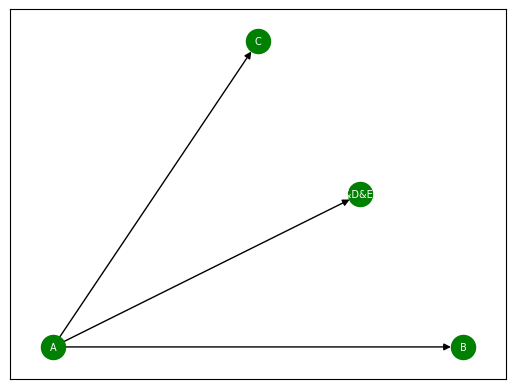

In [ ]:
res = rhs_to_graph("A->B; A->C; A->C&D&E*1")
expected = _create_graph(['A', 'B', 'C', 'C&D&E*1'], [('A','B'), ('A','C'), ('A','C&D&E*1')])
assert(_graphs_equal(expected, res))
_plot_graph(res)

#### RHS with User Value

In [ ]:
res = rhs_to_graph("""a; b; c[attr={{x}}]""", match = None, render_funcs={"x": lambda m: 5})
expected = _create_graph(['a', 'b', ('c',{"attr":5})], [])
assert(_graphs_equal(expected, res))
#_plot_graph(res)


res = rhs_to_graph("""a-[valy={{y}}]->b&c ; c[valx={{x}}]""", match = None, render_funcs={"x": lambda m: 5, "y": lambda m: 'hi'})
expected = _create_graph(['a', 'b&c', ('c',{'valx':5})], [('a','b&c',{'valy':'hi'})])
assert(_graphs_equal(expected, res))
#_plot_graph(res)